In [115]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [116]:
# List of African countries to exclude
african_countries = [
    "Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cameroon", "Cape Verde",
    "Central African Republic", "Chad", "Comoros", "Congo", "Djibouti", "Egypt", "Equatorial Guinea",
    "Eritrea", "Eswatini", "Ethiopia", "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau",
    "Ivory Coast", "Kenya", "Lesotho", "Liberia", "Libya", "Madagascar", "Malawi", "Mali",
    "Mauritania", "Mauritius", "Morocco", "Mozambique", "Namibia", "Niger", "Nigeria", "Rwanda",
    "Sao Tome and Principe", "Senegal", "Seychelles", "Sierra Leone", "Somalia", "South Africa",
    "South Sudan", "Sudan", "Tanzania", "Togo", "Tunisia", "Uganda", "Zambia", "Zimbabwe", 
    "Democratic Republic of the Congo", "Côte d'Ivoire", "Democratic Republic of Congo"
]

# Load the CSV file and rename columns
df = pl.read_csv("countries-in-conflict-data.csv").rename({
    "Entity": "country",
    "Code": "country_code",
    "Year": "year",
    "Deaths in ongoing conflicts in a country (best estimate) - Conflict type: all": "total_deaths"
}).select(["year", "country", "total_deaths"])

# Ensure data types for consistency
df = df.with_columns([
    pl.col("year").cast(pl.Int64),
    pl.col("total_deaths").cast(pl.Int64)
])

# Load the 2024 data and rename columns
df_2024 = pl.read_csv("acled_aggregated_20024.csv").rename({
    "Country": "country",
    "Fatalities": "total_deaths"
})

# Add a 'year' column with the value 2024 and ensure consistency in data types
df_2024 = df_2024.with_columns([
    pl.lit(2024).alias("year").cast(pl.Int64),
    pl.col("total_deaths").cast(pl.Int64)
]).select(["year", "country", "total_deaths"])

# Append the 2024 data to the main DataFrame
df_combined = df.vstack(df_2024)

# Remove any trailing or leading whitespace in the 'country' column
df_combined = df_combined.with_columns(
    pl.col("country").str.replace(r"^\s+|\s+$", "")  # This regex removes leading and trailing whitespace
)

# Filter the DataFrame for years between 2001 and 2024, excluding African countries
df_filtered = df_combined.filter(
    (pl.col("year") >= 2001) & (pl.col("year") <= 2024) & (~pl.col("country").is_in(african_countries))
)

# Sum up deaths per year across all non-African countries
deaths_per_year = (
    df_filtered.group_by("year")
    .agg(pl.col("total_deaths").sum().alias("Total Deaths"))
    .sort("year")
)


In [117]:
# Get unique countries from the combined DataFrame
unique_countries = df_combined.select("country").unique()

# Loop through each unique country and print it
for country in unique_countries["country"]:
    print(country)


United States
Grenada
Switzerland
Martinique
Mongolia
Cambodia
United Kingdom
Syria
French Guiana
Luxembourg
Wallis and Futuna
Marshall Islands
Italy
Paraguay
South Sudan
Sri Lanka
Moldova
Saudi Arabia
El Salvador
Bermuda
France
Palau
Albania
New Zealand
Antigua and Barbuda
Cape Verde
Israel
Bahamas
Algeria
North Korea
Vietnam
Faroe Islands
Singapore
French Polynesia
Cuba
Guam
Indonesia
Liechtenstein
Mauritania
Nicaragua
Bolivia
Czech Republic
Western Sahara
Curacao
Portugal
Brunei
Saint Vincent and the Grenadines
Maldives
Azerbaijan
Botswana
Tanzania
Chad
Antarctica
Fiji
Uruguay
Greece
Morocco
Guadeloupe
Uganda
Monaco
Malawi
Bangladesh
Panama
Rwanda
Costa Rica
Greenland
Congo
Yemen
Benin
Suriname
South Korea
Haiti
Romania
Denmark
Mauritius
Netherlands
Oman
Zimbabwe
Spain
Slovakia
Ecuador
Afghanistan
Qatar
Georgia
Senegal
Kazakhstan
Yemen People's Republic
Brazil
Mali
Iceland
Germany
Montenegro
Burkina Faso
United Arab Emirates
Seychelles
Nigeria
Ukraine
Libya
Nepal
Samoa
Micronesia (c

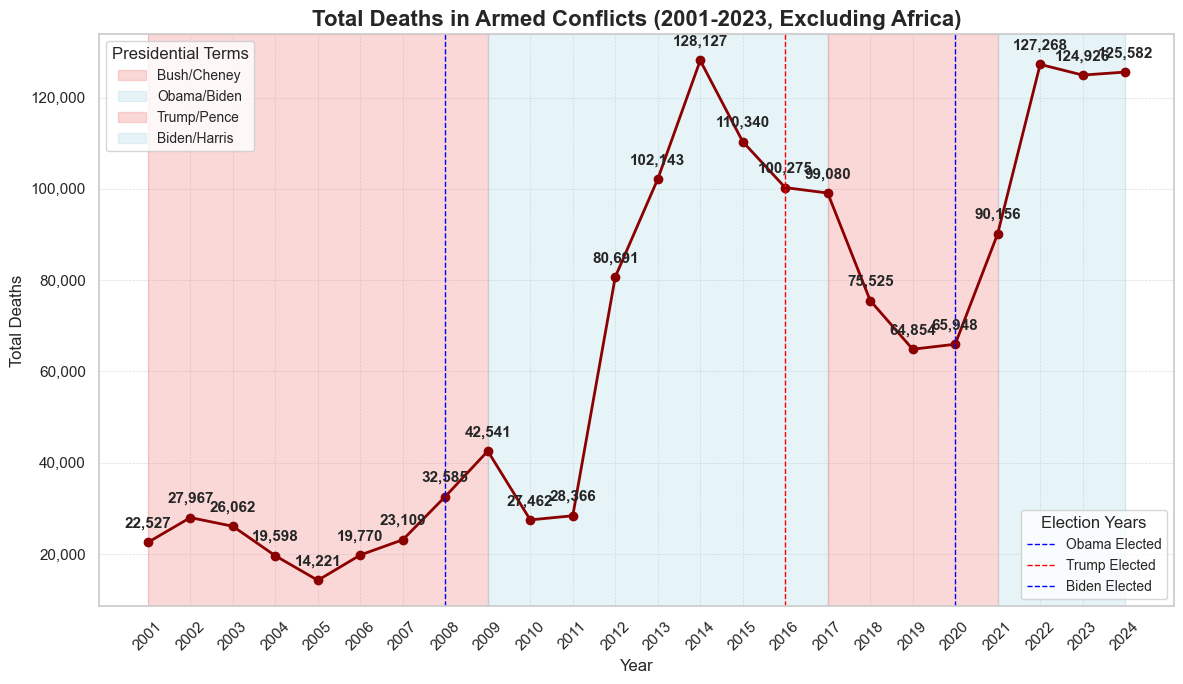

In [118]:
# Convert to pandas for plotting (Polars doesn't support plotting directly)
deaths_per_year = deaths_per_year.to_pandas()

# Set up a nice style
sns.set_theme(style="whitegrid")

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(deaths_per_year["year"], deaths_per_year["Total Deaths"], marker='o', linestyle='-', color='#8B0000', linewidth=2)  # Dark red color

# Adding vertical lines for election years
obama_elected = plt.axvline(x=2008, color='blue', linestyle='--', linewidth=1, label="Obama Elected")
trump_elected = plt.axvline(x=2016, color='red', linestyle='--', linewidth=1, label="Trump Elected")
biden_elected = plt.axvline(x=2020, color='blue', linestyle='--', linewidth=1, label="Biden Elected")

# Adding shaded regions for each presidency
bush = plt.axvspan(2001, 2009, color='lightcoral', alpha=0.3, label="Bush/Cheney")
obama = plt.axvspan(2009, 2017, color='lightblue', alpha=0.3, label="Obama/Biden")
trump = plt.axvspan(2017, 2021, color='lightcoral', alpha=0.3, label="Trump/Pence")
biden = plt.axvspan(2021, 2024, color='lightblue', alpha=0.3, label="Biden/Harris")

# Adding data labels above the points
for x, y in zip(deaths_per_year["year"], deaths_per_year["Total Deaths"]):
    plt.text(x, y + max(deaths_per_year["Total Deaths"]) * 0.02, f"{y:,}", ha="center", va="bottom", fontsize=11, weight='bold')

# Titles and labels
plt.title("Total Deaths in Armed Conflicts (2001-2023, Excluding Africa)", fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Deaths", fontsize=12)

# Format y-axis with commas
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

# Improving the x-axis ticks
plt.xticks(deaths_per_year["year"], rotation=45)

# Adding a subtle grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# First legend for presidential terms (upper left), excluding the election lines
first_legend = plt.legend(handles=[bush, obama, trump, biden], loc="upper left", fontsize=10, title="Presidential Terms")
plt.gca().add_artist(first_legend)

# Second legend for election years (bottom right)
plt.legend(handles=[obama_elected, trump_elected, biden_elected], loc="lower right", fontsize=10, title="Election Years")

# Show plot
plt.tight_layout()
plt.show()